# Maximizing nongaussianity
__Group ALT: Andreea, Laura, Tien __

## Exercise H6.1: Kurtosis of Toy Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io as sio
import seaborn as sns

In [2]:
########### TIEN
# https://gist.github.com/dkapitan/fcf45a97caaf48bc3d6be17b5f8b213c
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if (isinstance(self.sg, sns.axisgrid.FacetGrid) or isinstance(self.sg, sns.axisgrid.PairGrid)):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            n, m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = (gridspec.GridSpecFromSubplotSpec(r + 1, r + 1,
                        subplot_spec=self.subplot))

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        # https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())
        
        
def plt_jointplot(normal, laplac, unifor, add_title = ''):  # data must be of shape 2 x p
    fig = plt.figure(figsize=(13,4))
    gs = gridspec.GridSpec(1, 3)

    plt1 = sns.jointplot(x = normal[0], y = normal[1], kind = 'scatter')
    plt2 = sns.jointplot(x = laplac[0], y = laplac[1], kind = 'scatter')
    plt3 = sns.jointplot(x = unifor[0], y = unifor[1], kind = 'scatter')
    
    fig.suptitle(f'Normal, Laplacian and uniformly distributed {add_title}', fontsize = 13,y=1.05)
    
    mg0 = SeabornFig2Grid(plt1, fig, gs[0])
    mg1 = SeabornFig2Grid(plt2, fig, gs[1])
    mg2 = SeabornFig2Grid(plt3, fig, gs[2])
    
    gs.tight_layout(fig)
    plt.show()

In [3]:
def principal_components(centered_data):
    """
    gets centered data were the columns are different components and rows are different observations
    return: centered data, covariance matrix, sorted eigenvalues and normalized eigenvectors IN COLUMNS 
    in descending order
    """

    cov_matrix = np.cov(centered_data)
    eigenval, eigenvec = np.linalg.eig(cov_matrix)
    
    idx = eigenval.argsort()[::-1]
    sorted_eigenvals = eigenval[idx]
    sorted_eigenvecs = eigenvec[idx,:]
    
    sorted_eigenvecs = sorted_eigenvecs/np.linalg.norm(sorted_eigenvecs,axis=0)  # normalize eigenvectors
    return cov_matrix, sorted_eigenvals,sorted_eigenvecs

In [4]:
distrib = sio.loadmat("distrib.mat")
s_unifor = distrib["uniform"]
s_normal = distrib["normal"]
s_laplac = distrib["laplacian"]

N = 2
p = 10000

__(a) Apply the mixing matrix $\mathbf{A}$ to the original sources $\mathbf{s}$.__

In [5]:
A = np.array([[4,3],[2,1]])
x_normal = A @ s_normal
x_laplac = A @ s_laplac
x_unifor = A @ s_unifor

__(b) Center the mixtures $\mathbf{x}$ to zero mean.__

In [6]:
x_normal_cent = x_normal - np.mean(x_normal, axis = 1).reshape(2,1)
x_laplac_cent = x_laplac - np.mean(x_laplac, axis = 1).reshape(2,1)
x_unifor_cent = x_unifor - np.mean(x_unifor, axis = 1).reshape(2,1)

__(c) Decorrelate the mixtures from (b) by applying principal component analysis (PCA) on them
and project them onto the PCs.__

In [7]:
_, eigvals_normal ,pca_normal = principal_components(x_normal_cent)
_, eigvals_laplac ,pca_laplac = principal_components(x_laplac_cent)
_, eigvals_unifor ,pca_unifor = principal_components(x_unifor_cent)

In [8]:
x_normal_decorr = pca_normal.T @ x_normal_cent
x_laplac_decorr = pca_laplac.T @ x_laplac_cent
x_unifor_decorr = pca_unifor.T @ x_unifor_cent

lambda_inv_normal = np.diag(1/np.sqrt(eigvals_normal))
lambda_inv_laplac = np.diag(1/np.sqrt(eigvals_laplac))
lambda_inv_unifor = np.diag(1/np.sqrt(eigvals_unifor))

x_normal_sphere = lambda_inv_normal @ x_normal_decorr
x_laplac_sphere = lambda_inv_laplac @ x_laplac_decorr
x_unifor_sphere = lambda_inv_unifor @ x_unifor_decorr

__(e) Rotate the whitened mixtures by different angles $\theta$ and calculate the (excess) kurtosis empirically for each dimension in $\mathbf{x}$.__

In [9]:
def rotate(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

def kurtosis(x, theta):
    R = rotate(theta)
    x_theta = R @ x
    kurt = np.mean(x_theta**4, axis =1) - 3
    return kurt

In [10]:
thetas = np.arange(0,2*np.pi+np.pi/50, np.pi/50)

kurt_normal = np.zeros((len(thetas),2))
kurt_laplac = np.zeros((len(thetas),2))
kurt_unifor = np.zeros((len(thetas),2))

for i,theta in enumerate(thetas):
    kurt_normal[i] = kurtosis(x_normal_sphere, theta)
    kurt_laplac[i] = kurtosis(x_laplac_sphere, theta)
    kurt_unifor[i] = kurtosis(x_unifor_sphere, theta)


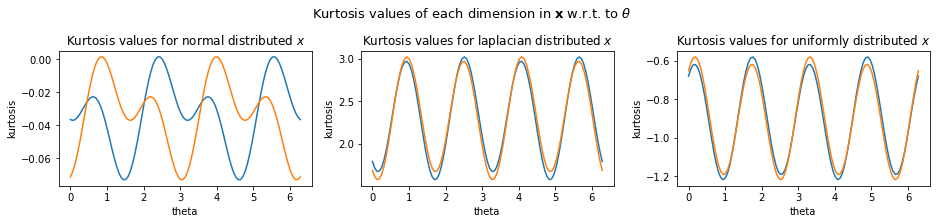

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (13, 3), constrained_layout = True)
kurts = [kurt_normal.T, kurt_laplac.T, kurt_unifor.T]
titles = ['normal', 'laplacian', 'uniformly']

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.plot(thetas, kurts[i][0])
    plt.plot(thetas, kurts[i][1])
    plt.xlabel('theta')
    plt.ylabel('kurtosis')
    plt.title(f'Kurtosis values for {titles[i]} distributed $x$')
    
fig.suptitle(r'Kurtosis values of each dimension in $\mathbf{x}$ w.r.t. to $\theta$', fontsize = 13)
plt.show()

__(f) Find the minimum and maximum kurtosis value for the first dimension and rotate the data accordingly.__

In [12]:
theta_normal_min, theta_normal_max = thetas[np.argmin(kurt_normal.T[0])],thetas[np.argmax(kurt_normal.T[0])]
theta_laplac_min, theta_laplac_max = thetas[np.argmin(kurt_laplac.T[0])],thetas[np.argmax(kurt_laplac.T[0])]
theta_unifor_min, theta_unifor_max = thetas[np.argmin(kurt_unifor.T[0])],thetas[np.argmax(kurt_unifor.T[0])]

In [13]:
def rotate_min_max(data, theta_min, theta_max):
    R_min = rotate(theta_min)
    R_max = rotate(theta_max)
    x_theta_min = R_min @ data
    x_theta_max = R_max @ data
    return x_theta_min, x_theta_max

In [14]:
x_normal_rot_min, x_normal_rot_max = rotate_min_max(x_normal_sphere, theta_normal_min, theta_normal_max)
x_laplac_rot_min, x_laplac_rot_max = rotate_min_max(x_laplac_sphere, theta_laplac_min, theta_laplac_max)
x_unifor_rot_min, x_unifor_rot_max = rotate_min_max(x_unifor_sphere, theta_unifor_min, theta_unifor_max)

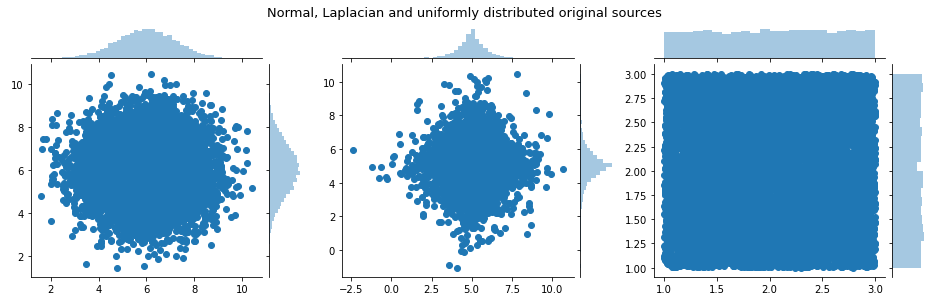

In [15]:
plt_jointplot(s_normal, s_laplac, s_unifor, 'original sources')

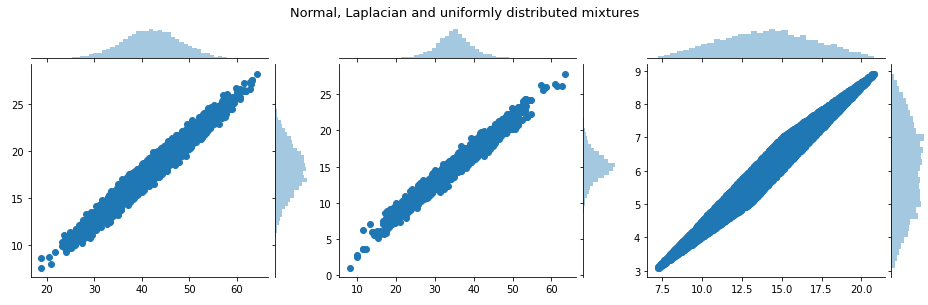

In [16]:
plt_jointplot(x_normal, x_laplac, x_unifor, 'mixtures')

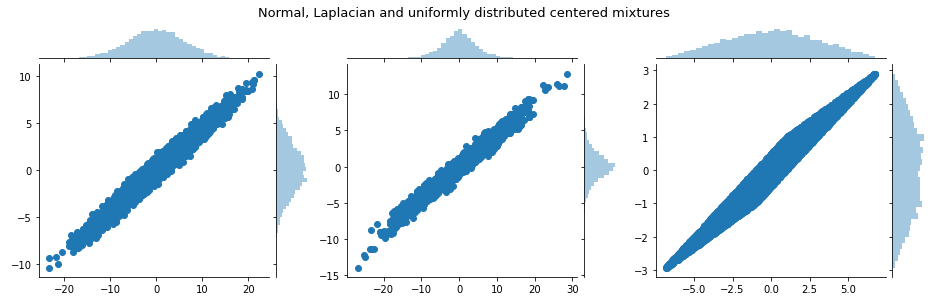

In [17]:
plt_jointplot(x_normal_cent, x_laplac_cent, x_unifor_cent, 'centered mixtures')

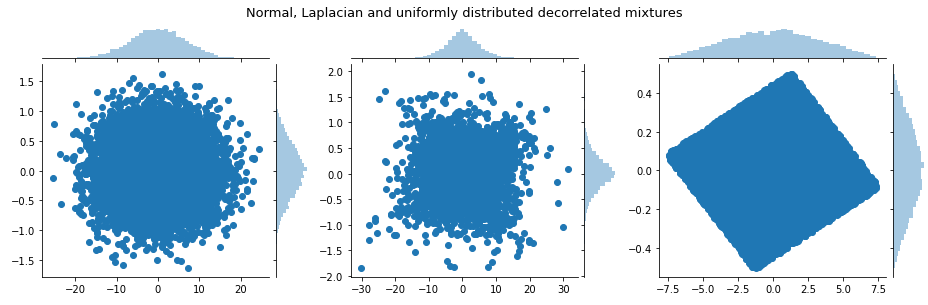

In [18]:
plt_jointplot(x_normal_decorr, x_laplac_decorr, x_unifor_decorr, 'decorrelated mixtures')

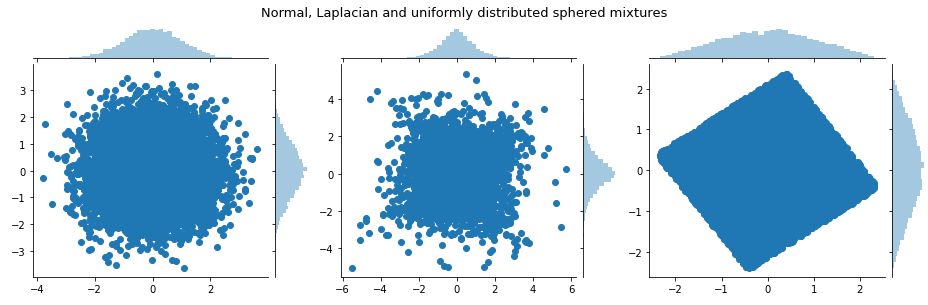

In [19]:
plt_jointplot(x_normal_sphere, x_laplac_sphere, x_unifor_sphere, 'sphered mixtures')

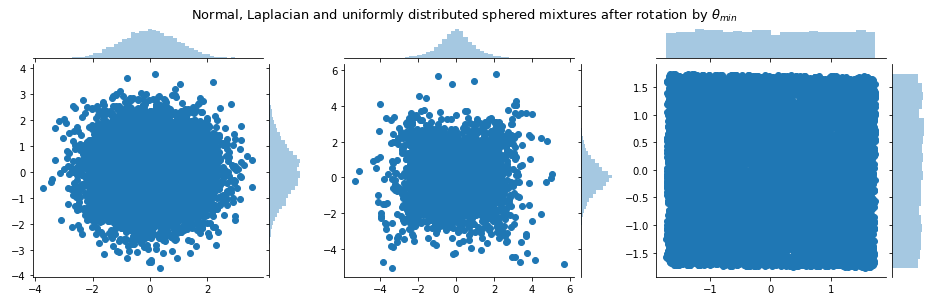

In [20]:
plt_jointplot(x_normal_rot_min, x_laplac_rot_min, x_unifor_rot_min, r'sphered mixtures after rotation by $\theta_{min}$ ')

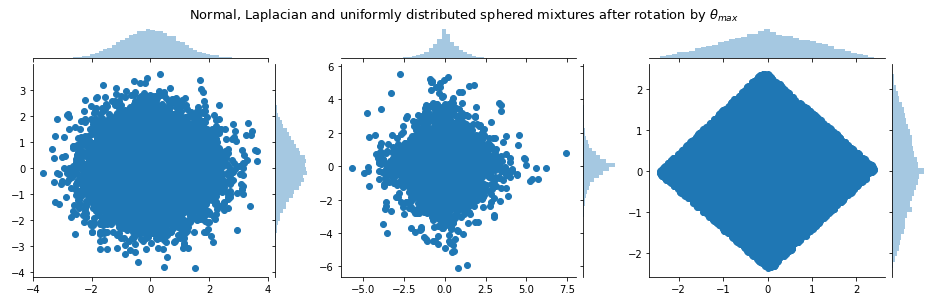

In [21]:
plt_jointplot(x_normal_rot_max, x_laplac_rot_max, x_unifor_rot_max, r'sphered mixtures after rotation by $\theta_{max}$ ')

In [22]:
print(f'Minimum kurtosis value of the normal distribution: {np.min(kurt_normal.T[0])}')
print(f'Maximum kurtosis value of the normal distribution: {np.max(kurt_normal.T[0])}')
print('')

print(f'Minimum kurtosis value of the Laplace distribution: {np.min(kurt_laplac.T[0])}')
print(f'Maximum kurtosis value of the Laplace distribution: {np.max(kurt_laplac.T[0])}')
print('')

print(f'Minimum kurtosis value of the uniform distribution: {np.min(kurt_unifor.T[0])}')
print(f'Maximum kurtosis value of the uniform distribution: {np.max(kurt_unifor.T[0])}')

Minimum kurtosis value of the normal distribution: -0.07290092529895587
Maximum kurtosis value of the normal distribution: 0.0013696690943216794

Minimum kurtosis value of the Laplace distribution: 1.584103194281238
Maximum kurtosis value of the Laplace distribution: 3.0186505751018835

Minimum kurtosis value of the uniform distribution: -1.216561706053717
Maximum kurtosis value of the uniform distribution: -0.581252500548497
